## Imports

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from time import time
from tqdm import tqdm, tqdm_notebook


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

## CUDA

In [96]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [97]:
device = torch.device('cuda' if train_on_gpu else 'cpu')

## Load data

In [98]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [99]:
trainset = datasets.MNIST('files/trainset', download=True, train=True, transform=transform)
testset = datasets.MNIST('files/testset', download=True, train=False, transform=transform)

In [100]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=4)

## Look at the data

In [101]:
images, labels = iter(trainloader).next()

In [102]:
images.shape

torch.Size([32, 1, 28, 28])

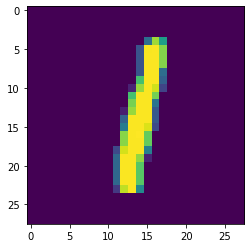

In [103]:
plt.imshow(images[0].numpy().squeeze())

In [104]:
labels[0]

tensor(1)

## Define network

In [151]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.pool0 = nn.MaxPool2d(kernel_size=2)
        
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv1_drop = nn.Dropout2d()
        
        self.fc0 = nn.Linear(in_features=1024, out_features=128)
        self.fc1 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        c0 = F.relu(self.pool0(self.conv0(x)))
        c1 = F.relu(self.pool1(self.conv1_drop(self.conv1(c0))))

        fl = c1.view(-1, 1024)
        
        f0 = F.relu(self.fc0(fl))
        f1 = F.dropout(f0, training=self.training)
        f2 = self.fc1(f1)
        return F.log_softmax(f2)

In [152]:
class MyNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1) # 28 -> 14
        self.pool0 = nn.MaxPool2d(2) # 14 -> 7
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1) # 7 -> 8
        self.pool1 = nn.MaxPool2d(2) # 8 -> 4
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) # 4 -> 4
        self.pool2 = nn.MaxPool2d(2) # 4 -> 2
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2) # 2 -> 1
        self.fc0 = nn.Linear(in_features=256, out_features=128)
        self.fc1 = nn.Linear(in_features=128, out_features=10)   
        
    def forward(self, x):
        c0 = F.relu(self.pool0(self.conv0(x)))
        c1 = F.relu(self.pool1(self.conv1(c0)))
        c2 = F.relu(self.pool2(self.conv2(c1)))  
        c3 = F.relu(self.conv3(c2))
        
        f = c3.view(32,256)
        print(f.shape)
        fc0 = F.relu(self.fc0(f))
        fc1 = F.log_softmax(self.fc1(fc0))
#         output = F.sigmoid(fc1)

        return fc1

## Training

In [153]:
random_seed = 23
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [154]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    val_losses = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).detach().cpu()
            val_loss = loss_fn(Y_hat, Y_val)
            val_losses.append(val_loss)

        # Visualize tools        
        
    return val_losses

In [155]:
model = Net().to(device)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [156]:
losses = train(model=model, opt=optimizer, loss_fn=criterion, epochs=15, data_tr=trainloader, data_val=testloader)

* Epoch 1/15


/home/philipp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


loss: 0.461505
* Epoch 2/15
loss: 0.153959
* Epoch 3/15
loss: 0.116699
* Epoch 4/15
loss: 0.096241
* Epoch 5/15
loss: 0.085818
* Epoch 6/15
loss: 0.075584
* Epoch 7/15
loss: 0.070547
* Epoch 8/15
loss: 0.064897
* Epoch 9/15
loss: 0.061992
* Epoch 10/15
loss: 0.058511
* Epoch 11/15
loss: 0.054844
* Epoch 12/15
loss: 0.052777
* Epoch 13/15
loss: 0.049594
* Epoch 14/15
loss: 0.046616
* Epoch 15/15
loss: 0.045331


## Results of training

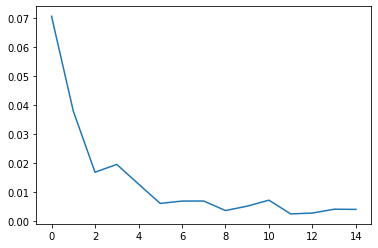

In [157]:
plt.plot(losses)

## Testing

In [158]:
def test(model, testloader):
    accuracy = 0.
    count_all = 0
    for X_val, Y_val in testloader:
        count_all += len(Y_val)
        Y_pred = model(X_val.to(device))
        Y_pred = torch.argmax(Y_pred, 1).to('cpu')
        true_predicted = (Y_pred == Y_val).sum()
        accuracy += true_predicted
    accuracy /= count_all
    return accuracy.numpy().item()

In [159]:
acc = test(model, testloader)

/home/philipp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [160]:
print('accuracy: {:.3f}%'.format(acc*100))

accuracy: 99.230%


## Visualize

In [161]:
X_val, Y_val = next(iter(testloader))
Y_pred = model(X_val.to(device))
Y_pred = torch.argmax(Y_pred, 1)

/home/philipp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


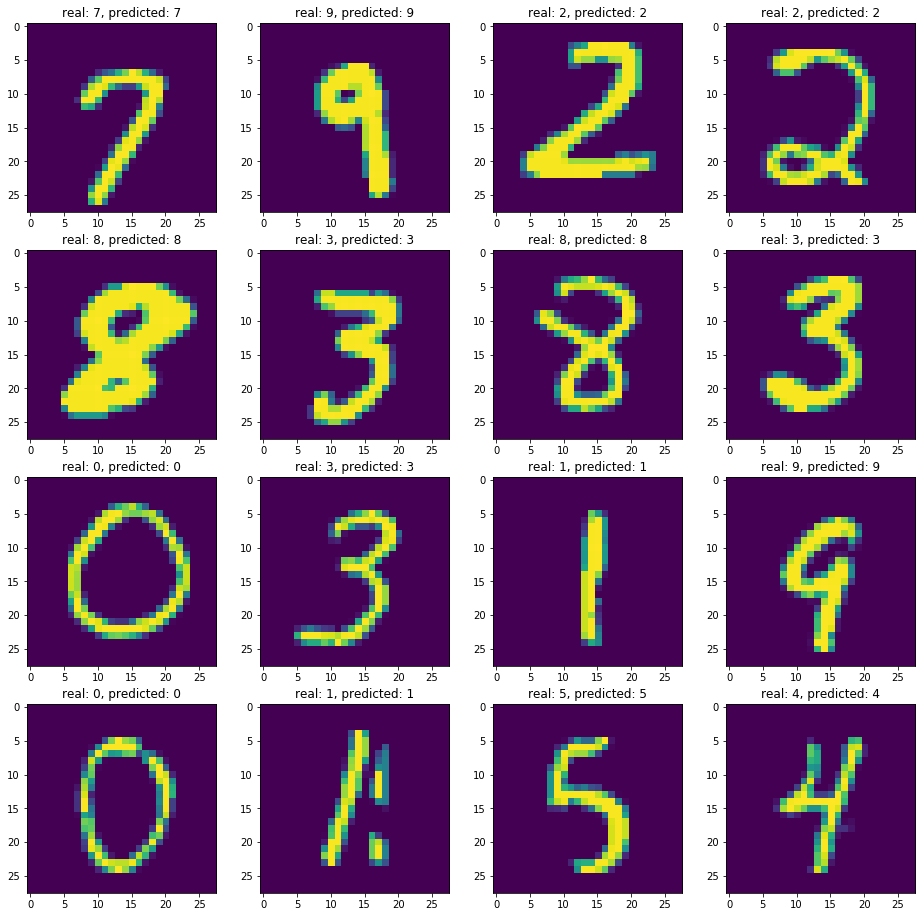

In [162]:
w=10
h=10
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_val[i].numpy().squeeze())
    plt.title('real: {}, predicted: {}'.format(Y_val[i].item(), Y_pred[i].item()))
plt.show()